In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pylcp
import scipy.constants as cts
from pylcp.common import progressBar
import pandas as pd

# Forces for $F = 2 \rightarrow F'=3$

Based on [this example](https://python-laser-cooling-physics.readthedocs.io/en/latest/examples/molasses/02_F2_to_F3_1D_molasses.html) from pyLCP. Changed sodium to potassium.

Current goals:
- Remove extra polarizations
- Add negative points to the domain of the force calculation.

## Dimensionless magnetic field

We need a dimenionless magnetic field unit for the simulation. `pyLCP` sets the following by default:
$$\mu_B = \hbar = \Gamma = k = 1$$
So, we need a natural unit of magnetic field. $$\mu_B$$ has units of energy per magnetic field. $$\hbar$$ has units of action, _i.e._ energy times time. $$\Gamma$$ has units of inverse time. Thus, we define a natural unit of magnetic field:
$$H_0 = \frac{\hbar \Gamma}{\mu_B}$$

Take the following values, in mostly SI units:

$\hbar = 6.58 \times 10^{-16} eV \cdot s$

$\Gamma = 2\pi 6 ~\textrm{MHz} = 2\pi \times 6.0 \times 10^{6} s^{-1}$ (for $^{41} K$, from Tiecke)

$\mu_B = 5.788 \times 10^{-5} \textrm{eV / T}$

In [44]:
hbar = 6.58e-16
gamma = 2.0 * 3.14 * 6.0 * 1e6
muB = 5.788e-5
h0 = hbar * gamma / muB
print("H_0 in Tesla", h0)
print("H_0 in Gauss", h0 * 1.0e4)

H_0 in Tesla 0.0004283593642017968
H_0 in Gauss 4.283593642017968


## Simulation of molasses forces with constant $B$ field.

In [45]:
atom = pylcp.atom('41K')
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

364.1948681855378


In [46]:
def return_hamiltonian(Fl, Delta):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, (Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, -Delta*np.eye(He.shape[0])+He, Bgq, Beq, dijq, mass=mass)

    return hamiltonian

# Now, make 1D laser beams:
def return_lasers(delta, s, pol):
    if pol[0][2]>0 or pol[0][1]>0:
        pol_coord = 'spherical'
    else:
        pol_coord = 'cartesian'

    return pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':pol[0],
         'pol_coord':pol_coord, 'delta':delta, 's':s},
        {'kvec':np.array([0., 0., -1.]), 'pol':pol[1],
         'pol_coord':pol_coord, 'delta':delta, 's':s},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

# Now make a bunch of polarization keys:
pols = {'$\\sigma^+\\sigma^-$':[np.array([0., 0., 1.]), np.array([1., 0., 0.])]}

In [47]:
det = -2.0
s = 1.0

hamiltonian = return_hamiltonian(2, det)

v = np.concatenate((np.arange(-5.1, -0.1, 0.1),
                    np.arange(-0.1, -0.03, 0.01),
                    np.arange(-0.03, -0.02, 0.005),
                    np.arange(-0.02, -0.01, 0.002),
                    np.arange(-0.01, -0.001, 0.001),
                    np.arange(0.001, 0.01, 0.001),
                    np.arange(0.01, 0.02, 0.002),
                    np.arange(0.02, 0.03, 0.005),
                    np.arange(0.03, 0.1, 0.01),
                    np.arange(0.1, 5.1, 0.1)))

obe = {}
for key_beam in pols:
    laserBeams = return_lasers(0., s, pol=pols[key_beam])

    obe[key_beam] = pylcp.obe(
        laserBeams, magField, hamiltonian,
        include_mag_forces=False, transform_into_re_im=True
    )

    obe[key_beam].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
        rel=1e-8, abs=1e-10, progress_bar=True
    )

Completed in 7:50.                                                  


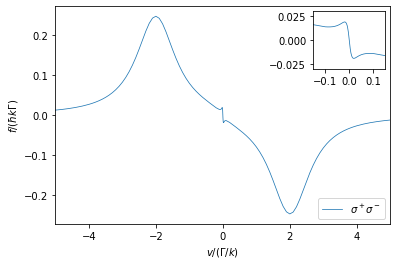

In [48]:
fig, ax = plt.subplots(1, 1)
axins = inset_axes(ax, width=1.0, height=0.8)
for key in obe:
    if 'phi' in key:
        linestyle='--'
    else:
        linestyle='-'

    ax.plot(
        v,
        obe[key].profile['molasses'].F[2],
        label=key, linestyle=linestyle,
        linewidth=0.75
    )
    axins.plot(
        v,
        obe[key].profile['molasses'].F[2],
        label=key, linestyle=linestyle,
        linewidth=0.75
    )

ax.set_xlim(-5.0, 5.0)
#ax.set_ylim(-0.05, 0.05)
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$')
axins.set_xlim(-0.15, 0.15)
axins.set_ylim(-0.03, 0.03)
ax.legend(loc="lower right")
plt.savefig("force.png")